# WEEK 5

In [1]:
import zipfile
with zipfile.ZipFile('/content/FruitinAmazon.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_folder')


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


In [3]:
# Define paths
train_dir = '/content/extracted_folder/FruitinAmazon/train'
test_dir = '/content/extracted_folder/FruitinAmazon/test'

In [4]:
# Get list of class directories
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Select one random image from each class
random_images = []
class_names = []

for class_name in class_dirs:
    class_path = os.path.join(train_dir, class_name)
    image_name = random.choice(os.listdir(class_path))  # Randomly select one image
    random_images.append(os.path.join(class_path, image_name))
    class_names.append(class_name)

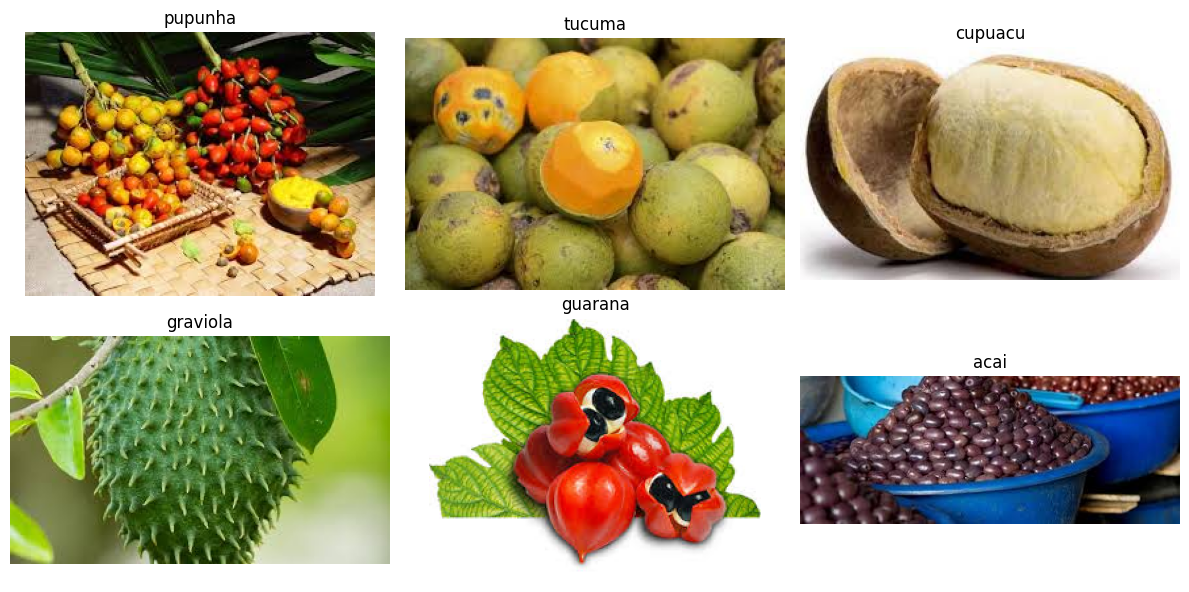

In [5]:
# Display images in a grid (2 rows)
plt.figure(figsize=(12, 6))
columns = (len(random_images) + 1) // 2
for i, img_path in enumerate(random_images):
    plt.subplot(2, columns, i + 1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(class_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

2. Check for Corrupted Image: Write a script that verifies whether the image in the train
directory are valid. If any corrupted images are found, the script must remove the image from
the directory and print the message which image have been removed, if none found print ”No
Corrupted Images Found.”
* Hint:
 * Iterate through each class subdirectory and check if each image is valid.
 * Use the Image.open() function to attempt to load each image.
 * If the image is corrupted i.e. raises an IOError or SyntaxError, remove the image from
the directory and print ```f"Removed corrupted image: {image_path}"```.
 * Maintain a list of all corrupted image paths for reporting.
* Expected Output: No corrupted images found.


In [6]:

# List to store corrupted image paths
corrupted_images = []

# Iterate through class directories
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img.verify()  # Verify the image integrity
            except (IOError, SyntaxError):
                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")



# Final report
if corrupted_images:
    print(f"Total corrupted images removed: {len(corrupted_images)}")
else:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


In [35]:
# Define the path to your train directory and parameters
img_height = 128  # Desired image height
img_width = 128   # Desired image width
img_shape = (img_height, img_width,3)
batch_size = 32   # Number of images per batch
validation_split = 0.2  # 20% data for validation

# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255)  # Normalize pixel values to [0, 1]


In [36]:
# Load the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',         # Automatically infer the labels from subdirectories
    label_mode='int',          # Labels as integers (could also use 'categorical' or 'binary')
    image_size=(img_height, img_width),  # Resize images to this shape
    interpolation='nearest',   # Interpolation method for resizing
    batch_size=batch_size,     # Batch size for training
    shuffle=True,              # Shuffle the data
    validation_split=validation_split,  # Split data for training and validation
    subset='training',         # Specify this is for training subset
    seed=123                   # Random seed for reproducibility
)

# Apply the normalization (Rescaling) to the training dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))


Found 90 files belonging to 6 classes.
Using 72 files for training.


In [37]:
# Load the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',         # Automatically infer the labels from subdirectories
    label_mode='int',          # Labels as integers
    image_size=(img_height, img_width),  # Resize images
    interpolation='nearest',   # Interpolation method for resizing
    batch_size=batch_size,     # Batch size for validation
    shuffle=True,              # Shuffle the validation data
    validation_split=validation_split,  # Same validation split for validation
    subset='validation',       # Specify this is for validation subset
    seed=123                   # Random seed for reproducibility
)

# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))



Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [38]:

# Define the model
modelcnn = keras.Sequential([
    # First Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=img_shape),  # (3, 3) filter, 32 filters input_layer= 128x128 for 3 layers:R,G,B
    layers.MaxPooling2D((2, 2), strides=2),  # Max pooling with (2, 2) filter, stride 2

    # Second Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # (3, 3) filter, 32 filters
    layers.MaxPooling2D((2, 2), strides=2),  # Max pooling with (2, 2) filter, stride 2

    # Flatten the output to feed into dense layers
    layers.Flatten(),

    # Fully connected hidden layers
    layers.Dense(64, activation='relu'),  # Hidden layer with 64 neurons
    layers.Dense(128, activation='relu'),  # Hidden layer with 128 neurons

    # Output layer with the number of classes
    layers.Dense(6, activation='softmax')  # 6 classes for fruit types
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:

# Print the model summary
modelcnn.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Compile the model
modelcnn.compile(
    optimizer='adam',  # Optimizer: Adam
    loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification with integer labels
    metrics=['accuracy']  # Evaluation metric: Accuracy
)

In [41]:
# Display the compiled model summary
modelcnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [43]:
# Define the callbacks
callbacks = [
    # Save the best model based on validation accuracy
    ModelCheckpoint(
        'best_model.h5',  # Path to save the best model
        save_best_only=True,  # Save only the best model
        monitor='val_loss',  # Monitor validation loss
        mode='min',  # Minimize the validation loss
        verbose=1
    ),
    # Stop training if validation loss doesn't improve for 10 epochs
    EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=10,  # Wait for 10 epochs before stopping
        restore_best_weights=True,  # Restore best weights after stopping
        verbose=1
    )
]

In [44]:
# Train the model
history = modelcnn.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=250,  # Number of epochs
    batch_size=16,  # Batch size
    callbacks=callbacks  # Callbacks for early stopping and saving the best model
)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.1655 - loss: 1.9007
Epoch 1: val_loss improved from inf to 2.02240, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 595ms/step - accuracy: 0.1623 - loss: 1.9141 - val_accuracy: 0.1667 - val_loss: 2.0224
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.0648 - loss: 1.8747
Epoch 2: val_loss improved from 2.02240 to 1.83001, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 498ms/step - accuracy: 0.0660 - loss: 1.8759 - val_accuracy: 0.0556 - val_loss: 1.8300
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.3385 - loss: 1.5949
Epoch 3: val_loss improved from 1.83001 to 1.80815, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - accuracy: 0.3477 - loss: 1.5924 - val_accuracy: 0.2222 - val_loss: 1.8082
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7101 - loss: 1.3809
Epoch 4: val_loss improved from 1.80815 to 1.70726, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 503ms/step - accuracy: 0.7096 - loss: 1.3725 - val_accuracy: 0.2222 - val_loss: 1.7073
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.5747 - loss: 1.0996
Epoch 5: val_loss did not improve from 1.70726
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 839ms/step - accuracy: 0.5768 - loss: 1.1007 - val_accuracy: 0.2778 - val_loss: 1.8374
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.7321 - loss: 0.8722
Epoch 6: val_loss did not improve from 1.70726
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 445ms/step - accuracy: 0.7192 - loss: 0.8834 - val_accuracy: 0.2778 - val_loss: 2.1224
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8200 - loss: 0.6785
Epoch 7: val_loss did not improve from 1.70726
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - accuracy: 0.8199 - loss: 0.6802 - val_accuracy: 0.5000 - val_loss: 1.8076
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7980 - loss: 0.5498
Epoch 8: val_loss improved from 1.70726 to 1.58227, saving 

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.8103 - loss: 0.5418 - val_accuracy: 0.3889 - val_loss: 1.5823
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9508 - loss: 0.3271
Epoch 9: val_loss did not improve from 1.58227
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - accuracy: 0.9457 - loss: 0.3367 - val_accuracy: 0.3333 - val_loss: 1.7199
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 1.0000 - loss: 0.1619
Epoch 10: val_loss did not improve from 1.58227
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 762ms/step - accuracy: 1.0000 - loss: 0.1609 - val_accuracy: 0.5556 - val_loss: 1.7468
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9797 - loss: 0.1700
Epoch 11: val_loss did not improve from 1.58227
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - accuracy: 0.9813 - loss: 0.1644 - val_accuracy: 0.3889 - val_loss: 1.6957
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 1.0000 - loss: 0.0595
Epoch 12: val_loss did not improve from 1.58227
3/3 ━━

In [47]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    seed=28             # No shuffling for consistent evaluation
)

# Apply the same normalization as train/val
test_ds = test_ds.map(lambda x, y: (rescale(x), y))


Found 30 files belonging to 6 classes.


In [48]:

# Evaluate the model on the test dataset
test_loss, test_accuracy = modelcnn.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.5667 - loss: 0.9934
Test Loss: 0.9934, Test Accuracy: 0.5667



Plotting training history (accuracy and loss)


In [49]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 12))


<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

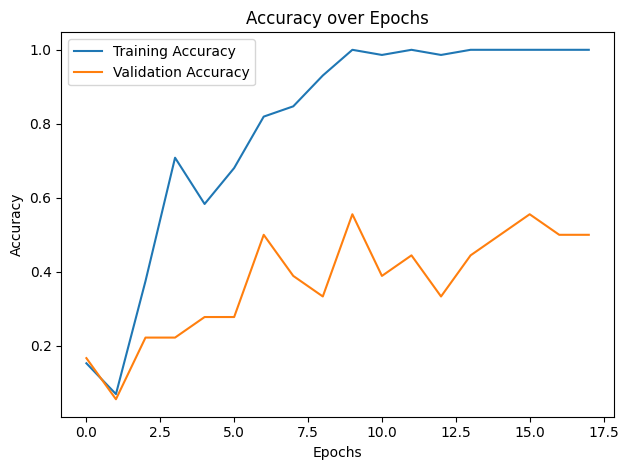

In [50]:
# Accuracy plot

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

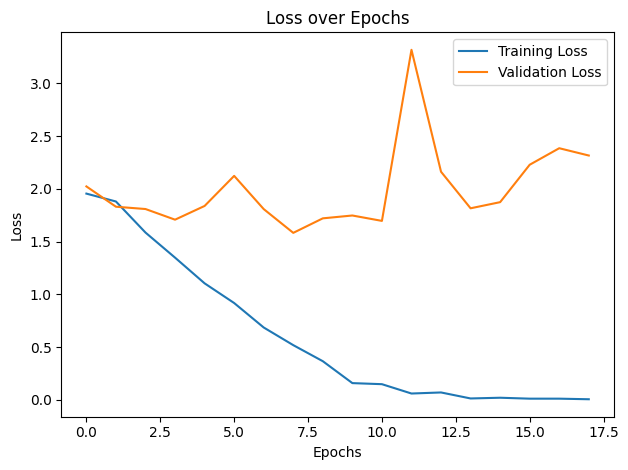

In [51]:

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Task - 1:
Repeat all the task from worksheet - 5 but, try to improve the model from last week with same dataset.
* Use Data Augmentation to increase the number of training image.
* Use deeper model with BN and DropOut layer as presented above.
* Understand the Model Summary and Training Behavior.

In [52]:
data_augmentation_layers = [
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
]

def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

In [54]:
# Define an improved CNN model with Batch Normalization and Dropout
modelcnn2 = keras.Sequential([

    # Data augmentation applied using Lambda layer
    layers.Lambda(data_augmentation, input_shape=img_shape),

    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(6, activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
# Compile the model
modelcnn2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [56]:
# Display model summary
modelcnn2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 8,485,574 (32.37 MB)

 Trainable params: 8,484,614 (32.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [57]:
# Train the model
cnn_history = modelcnn2.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=250,  # Number of epochs
    batch_size=32,  # Batch size
    callbacks=callbacks  # Callbacks for early stopping and saving the best model
    # jit_compile =False # Remove this line - it's not a valid argument for model.fit
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2251 - loss: 2.9077
Epoch 1: val_loss did not improve from 1.58227
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2244 - loss: 2.9291 - val_accuracy: 0.1667 - val_loss: 1.8004
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5052 - loss: 1.3635
Epoch 2: val_loss did not improve from 1.58227
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5039 - loss: 1.3705 - val_accuracy: 0.1667 - val_loss: 1.8845
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6800 - loss: 0.9786
Epoch 3: val_loss did not improve from 1.58227
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6801 - loss: 0.9732 - val_accuracy: 0.1667 - val_loss: 1.9519
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5943 - loss: 1.0507
Epoch 4: val_loss did not improve from 1.58227
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5985 - loss: 1.0451 - val_accuracy: 0.1667 - val_loss: 2.0272
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━

In [58]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,              # No shuffling for consistent evaluation
)

# Apply the same normalization as train/val
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Evaluate the model on the test dataset
test_loss, test_accuracy = modelcnn2.evaluate(test_ds)
print(f"\n\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.1667 - loss: 1.8032


Test Loss: 1.8032, Test Accuracy: 0.1667


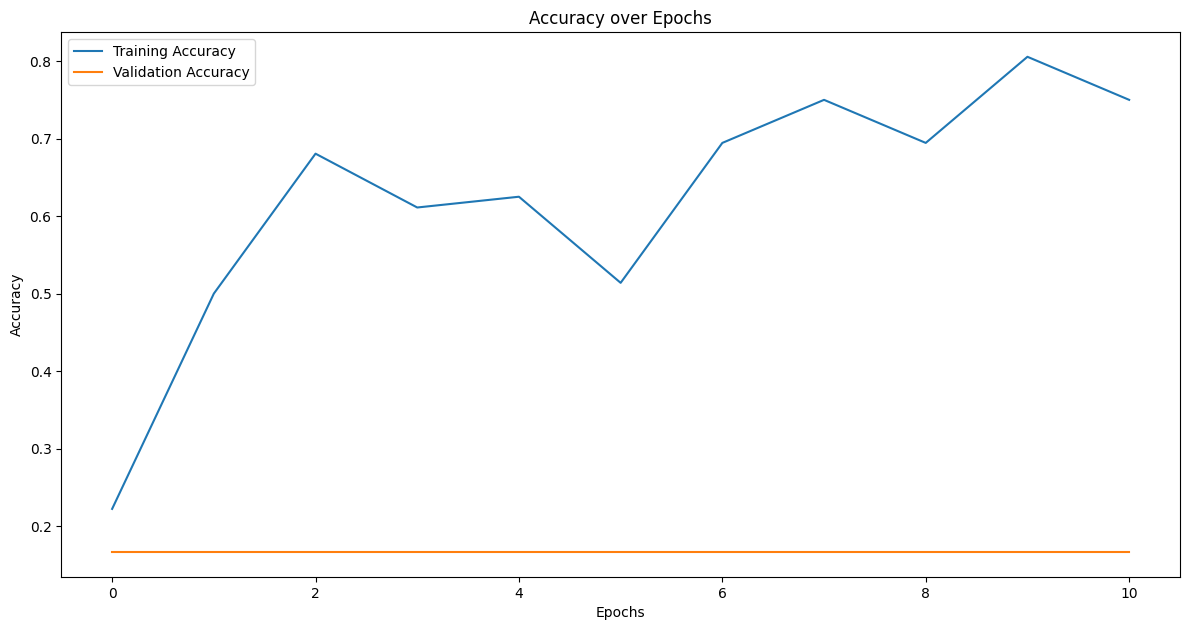

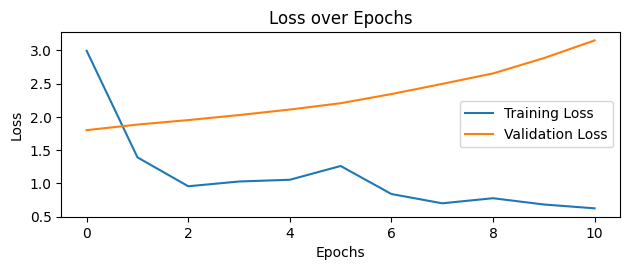

In [59]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 12))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# MobilenetV2


In [60]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

# Define input shape
input_shape = (128, 128, 3)
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)  # Adjust to your number of classes

# Create the model
modelnetv2 = Model(inputs, outputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [61]:
from tensorflow.keras.optimizers import Adam

modelnetv2.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [62]:
vnet2_history = modelnetv2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.2812 - loss: 2.0459
Epoch 1: val_loss did not improve from 1.58227
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2734 - loss: 2.0468 - val_accuracy: 0.3889 - val_loss: 1.6364
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.7147 - loss: 0.9975
Epoch 2: val_loss improved from 1.58227 to 1.44784, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 580ms/step - accuracy: 0.7166 - loss: 0.9810 - val_accuracy: 0.5000 - val_loss: 1.4478
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8553 - loss: 0.5036
Epoch 3: val_loss improved from 1.44784 to 1.24084, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 521ms/step - accuracy: 0.8533 - loss: 0.4986 - val_accuracy: 0.6111 - val_loss: 1.2408
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9606 - loss: 0.2251
Epoch 4: val_loss improved from 1.24084 to 0.99488, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 891ms/step - accuracy: 0.9566 - loss: 0.2250 - val_accuracy: 0.6667 - val_loss: 0.9949
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9803 - loss: 0.1158
Epoch 5: val_loss improved from 0.99488 to 0.89050, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 530ms/step - accuracy: 0.9783 - loss: 0.1179 - val_accuracy: 0.7778 - val_loss: 0.8905
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9797 - loss: 0.0705
Epoch 6: val_loss improved from 0.89050 to 0.87160, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.9813 - loss: 0.0681 - val_accuracy: 0.7778 - val_loss: 0.8716
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9797 - loss: 0.0468
Epoch 7: val_loss did not improve from 0.87160
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - accuracy: 0.9813 - loss: 0.0460 - val_accuracy: 0.7778 - val_loss: 0.8891
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 1.0000 - loss: 0.0234
Epoch 8: val_loss did not improve from 0.87160
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step - accuracy: 1.0000 - loss: 0.0235 - val_accuracy: 0.7778 - val_loss: 0.9355
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 1.0000 - loss: 0.0196
Epoch 9: val_loss did not improve from 0.87160
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step - accuracy: 1.0000 - loss: 0.0194 - val_accuracy: 0.7778 - val_loss: 0.9852
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 1.0000 - loss: 0.0145
Epoch 10: val_loss did not improve from 0.87160
3/3 ━━━━━━

In [63]:
modelnetv2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,752,212 (10.50 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 329,486 (1.26 MB)

In [64]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,              # No shuffling for consistent evaluation
)

# Apply the same normalization as train/val
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Evaluate the model on the test dataset
test_loss, test_accuracy = modelnetv2.evaluate(test_ds)
print(f"\n\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8333 - loss: 0.6664


Test Loss: 0.6664, Test Accuracy: 0.8333


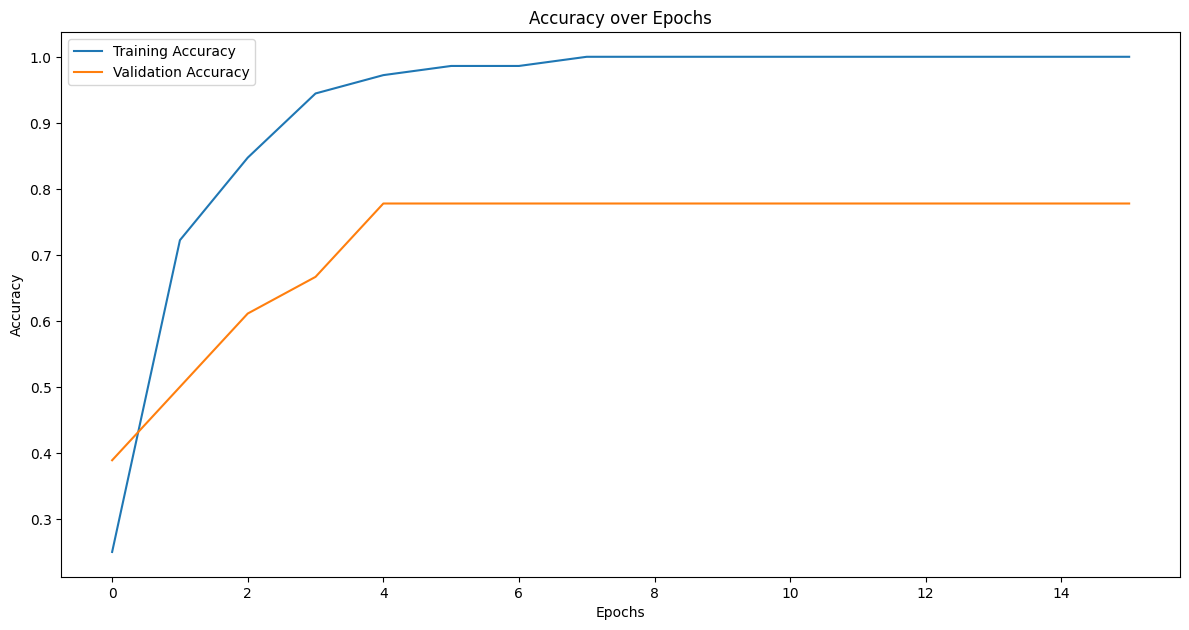

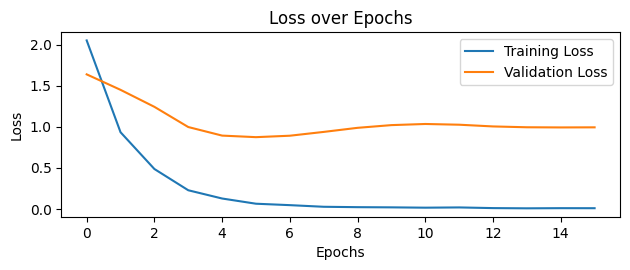

In [65]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 12))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(vnet2_history.history['accuracy'], label='Training Accuracy')
plt.plot(vnet2_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(vnet2_history.history['loss'], label='Training Loss')
plt.plot(vnet2_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# VGG16

In [66]:
# --- Transfer Learning using VGG16 ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

In [67]:
# Load the VGG16 model pre-trained on ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [68]:
for layer in base_model.layers:
  layer.trainable = False

In [69]:
# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces dimensions (height, width) to a single vector per image
x = Dense(1024, activation='relu')(x) # Fully connected layer with 1024 neurons
x = Dense(10, activation='softmax')(x) # Output layer for 10 classes (with softmax for multi-class classification)


In [70]:
from tensorflow.keras.models import Model
# Create the final model
modelvgg16 = Model(inputs=base_model.input, outputs=x)

In [71]:
from tensorflow.keras.optimizers import Adam
# Compile the model
modelvgg16.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [72]:
vgg_history = modelvgg16.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0903 - loss: 2.2173
Epoch 1: val_loss did not improve from 0.87160
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.0885 - loss: 2.2005 - val_accuracy: 0.3333 - val_loss: 1.7110
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5359 - loss: 1.5188
Epoch 2: val_loss did not improve from 0.87160
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - accuracy: 0.5304 - loss: 1.5163 - val_accuracy: 0.5000 - val_loss: 1.5357
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5781 - loss: 1.2914
Epoch 3: val_loss did not improve from 0.87160
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.5898 - loss: 1.2847 - val_accuracy: 0.4444 - val_loss: 1.4952
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5938 - loss: 1.1268
Epoch 4: val_loss did not improve from 0.87160
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - accuracy: 0.6016 - loss: 1.1203 - val_accuracy: 0.4444 - val_loss: 1.4821
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━

In [73]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,              # No shuffling for consistent evaluation
)

# Apply the same normalization as train/val
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Evaluate the model on the test dataset
test_loss, test_accuracy = modelvgg16.evaluate(test_ds)
print(f"\n\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5000 - loss: 1.3506


Test Loss: 1.3506, Test Accuracy: 0.5000


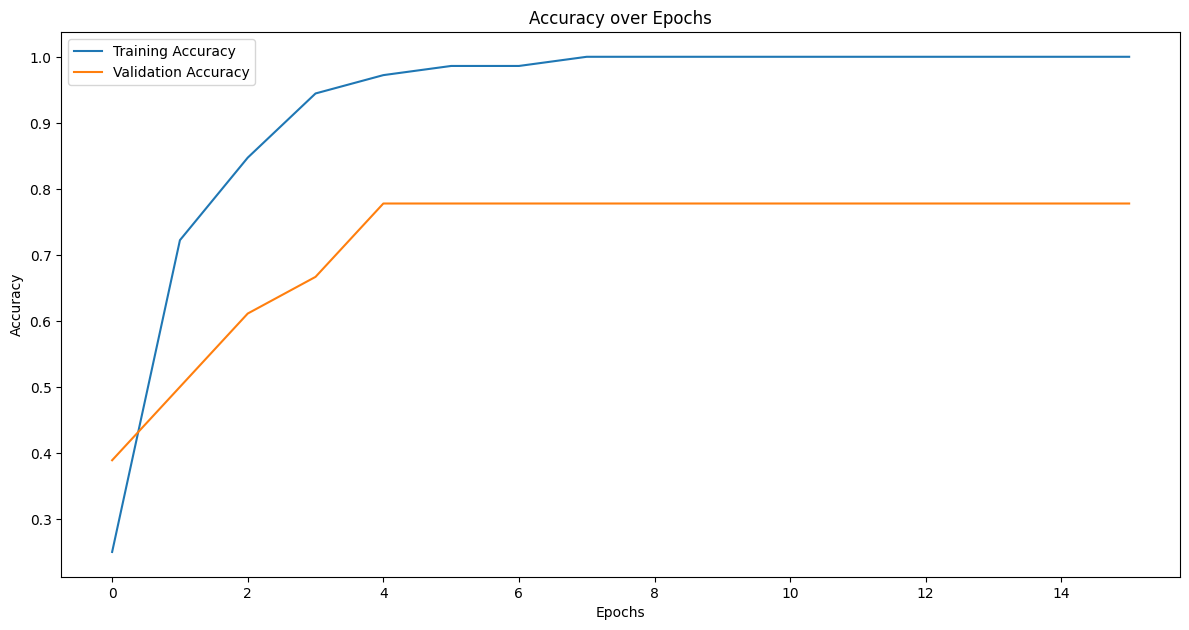

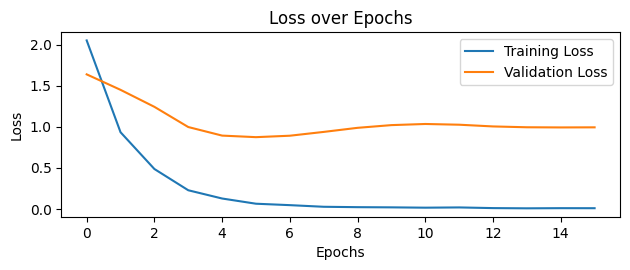

In [74]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 12))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(vnet2_history.history['accuracy'], label='Training Accuracy')
plt.plot(vnet2_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(vnet2_history.history['loss'], label='Training Loss')
plt.plot(vnet2_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()